# Data cleaning

## Setup

In [465]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rootpath
import re
import qgrid
import glob

# Set root path for project
path = rootpath.detect()

# Read in data
# Use list comprehension to read in all files
# Cleansers
## Oily skin
df_cleanser_oily = pd.concat([pd.read_csv(file, index_col=0) for file in glob.glob(f"{path}/data/cleansers_face-wash_oilyskin_pg*.csv")], ignore_index=True)
## Dry skin
df_cleanser_dry = pd.concat([pd.read_csv(file, index_col=0) for file in glob.glob(f"{path}/data/cleansers_face-wash_dryskin_pg*.csv")], ignore_index=True)
## Normal skin
df_cleanser_normal = pd.concat([pd.read_csv(file, index_col=0) for file in glob.glob(f"{path}/data/cleansers_face-wash_normalskin_pg*.csv")], ignore_index=True)

# Toners
df_toner_normal = pd.concat([pd.read_csv(file, index_col=0) for file in glob.glob(f"{path}/data/cleansers_toner_normalskin_pg1.csv")], ignore_index=True)
df_toner_dry = pd.concat([pd.read_csv(file, index_col=0) for file in glob.glob(f"{path}/data/cleansers_face-wash_dryskin_pg1.csv")], ignore_index=True)
df_toner_oily = pd.concat([pd.read_csv(file, index_col=0) for file in glob.glob(f"{path}/data/cleansers_face-wash_oilyskin_pg1.csv")], ignore_index=True)

# Treatments and serums
df_serum_oily = pd.concat([pd.read_csv(file, index_col=0) for file in glob.glob(f"{path}/data/treatments and serums_face serum_oilyskin.csv")], ignore_index=True)
df_serum_dry = pd.concat([pd.read_csv(file, index_col=0) for file in glob.glob(f"{path}/data/treatments and serums_face serum_dryskin.csv")], ignore_index=True)


## Examine data

In [25]:
df_cleanser_oily.shape

(238, 14)

In [26]:
df_cleanser_dry.shape

(208, 14)

In [27]:
df_cleanser_normal.shape

(267, 14)

In [475]:
df_cleansers = pd.concat([df_cleanser_oily,df_cleanser_dry,df_cleanser_normal,
                          df_toner_normal, df_toner_dry, df_toner_oily,
                         df_serum_oily,df_serum_dry], axis=0)
#df_cleansers.shape

In [29]:
qgrid.show_grid(df_cleansers, grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [471]:
df_cleansers.describe()

,ratings,page
count,651.000000,662.000000
mean,4.395392,1.364048
std,0.362611,0.656936
min,2.800000,1.000000
25%,4.200000,1.000000
50%,4.500000,1.000000
75%,4.600000,2.000000
max,5.000000,3.000000


In [468]:
df_cleansers.dtypes

use_category        object
use_subcategory     object
skintype            object
brand               object
product             object
size                object
price               object
details             object
ingredients         object
ratings            float64
perc_respondrec     object
total_reviews       object
link                object
page                 int64
dtype: object

## Data cleaning

### Remove rows with problematic data

In [476]:
# Filter rows without size information
# df_cleansers[df_cleansers['size'].str.contains('Item')]

# Remove rows with no size information
df_cleansers.drop(df_cleansers[df_cleansers['size'].str.contains('Item', na=False)].index, inplace=True)
df_cleansers.drop(df_cleansers[df_cleansers['size'].str.contains('ounce', na=False)].index, inplace=True)
df_cleansers.drop(df_cleansers[df_cleansers['size'].str.contains('Original', na=False)].index, inplace=True)
df_cleansers.drop(df_cleansers[df_cleansers['size'].str.contains(' ct', na=False)].index, inplace=True)

# Remove rows with no ingredient information
df_cleansers.dropna(subset=['ingredients'], inplace = True)

# Remove incorrect ingredients
df_cleansers.drop(df_cleansers[df_cleansers['ingredients'].str.contains('This item is not eligible for coupon discounts')].index, inplace=True)

# Remove incorrect sizes
df_cleansers.drop(df_cleansers[df_cleansers['size'].str.contains('Calm|Hydrating|Imperfections')].index, inplace=True)


# Remove travel size items
df_cleansers.drop(df_cleansers[df_cleansers['product'].str.contains('Travel Size')].index, inplace=True)

In [472]:
qgrid.show_grid(df_cleansers, grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

### Regex

In [159]:
pd.set_option('display.max_seq_items', 2000)
pd.set_option('display.max_rows', 2000)

In [477]:
df2 = df_cleansers.copy()
# FOR ALL: CHECK dtype AFTER MANIPULATION

# Size
# Remove oz and select original price only

# Check unique sizes
#df_cleansers['size'].unique()

# Remove 'size' and 'oz|'
df2['size'] = df2['size'].str.replace('Size | oz| oz\||\|','').astype('float64')

# Remove price text
#df_cleansers['price'].unique()
df2['price'] = df2['price'].str.replace('Price\\n\$|Sale Price\\n\$\d*\.\d*\\nOriginal Price\\n\$|Price\\n\$|\\nMarket Value\\n\(\$39 value\)','').astype('float64')

# Remove reviews text
df2['total_reviews'] = df2['total_reviews'].str.replace(' Reviews| Review','')#.astype('Int64')#.astype(float).astype(int)
df2['total_reviews'] = pd.to_numeric(df2['total_reviews'],errors='coerce',downcast='signed')
df2['total_reviews'] = df2['total_reviews'].astype('Int64')


# Get the first ingredient after splitting into strings to figure out water regex
# Change string of ingredients into a list containing a string for each ingredient, split by the following characters
df2.ingredients = df2.ingredients.str.split(r',|\\n') # |\.
## NEED TO FIX PERIOD B/C AFFECTS ACTIVE INGREDIENTS

# strip whitespace from around each ingredient
df2.ingredients = [[ingredient.strip().lower() for ingredient in product] for product in df2.ingredients]
df2 = df2.explode('ingredients')

# for ingredient in df2.ingredients:
#     if 'water' in ingredient:
#         df2.newcol = 'yes'
#     else:
#         df2.newcol = 'no'

# Replace all rows that contain string water with water, get rid of alternative spellings
df2['ingredients'] = np.where(df2['ingredients'].str.contains('water'), 'water', df2['ingredients'])  
# Same for fragrance
df2['ingredients'] = np.where(df2['ingredients'].str.contains('fragrance'), 'fragrance', df2['ingredients'])  
        
test = df2['ingredients'].unique()

# Create column for presence of ingredient in a product (excluding absences and does not account for all possible ingredients)
df2['ingred_value'] = 1
df2['skintype_value'] = 1  
## CHANGE INTO REVERSE SEQUENCE FOR ORDINAL ENCODING LATER

#df2.ingredients[:10]
# Replace strings that contain 'water' with water
# for product in df2.ingredients:
#     for ingredientlist in product:
#         for ingredient in ingredientlist:
#             if 'water' in ingredient:
#                 ingredient = ingredient.replace('^.*(water).*','water')
#                 product[ingredientlist][ingredient] = ingredient.replace(ingredient,'water')
#df2.ingredients[:10]
# for product in df2.ingredients:
#     for ingredientlist in product:
#             if 'water' in ingredientlist:
#                 product[ingredientlist] = ingredientlist.replace(ingredientlist,'water')
#         for ingredient in ingredientlist:
#             if 'water' in ingredient:
#                 df2.ingredients[i] = 'water'
#df2.ingredients.iloc[1]#[0]
#df2.ingredients = [product.split(',|\\n|\.') for product in df2.ingredients]
#df_cleansers['ingredients'] = [[ingredient for ingredient in str(product).split(', |\\n|\.')] for product in df_cleansers.ingredients]
#df2.ingredients=[[ingredient.split(', ') for ingredient in product] for product in df2.ingredients]
# Separate ingredient lists into lists of strings for each product
#test = [[ingredient.lower() for ingredient in product] for product in test] # df_cleansers.ingredients
#df_cleansers.ingredients = [[ingredient.lower() for ingredient in product] for product in df_cleansers.ingredients]
#df2.ingredients.str.split(',')
#test[:5]
# Look at first ingredient of each product for reformatting water
#test = [ingredient[0] for ingredient in df_cleansers.ingredients]
#np.unique(test)

# test2 = [ingredient.str.replace('\(([^)]+)\)| \/ aqua \/ eau|\/aqua\/eau|\\\\aqua\\\\eau|' \
#                                '\(mineral spring water\)| purified| \(solvent\/diluent\)|' \
#                                ' \(water/eau\)|') for ingredient in df_cleansers.ingredients]
# test2 = [[ingredient.replace('.*(water).*', '') for ingredient in product] for product in df2.ingredients]
# test2
#df2.ingredients[:10]
# test1 = df2.ingredients.iloc[1]
# test3 = test1[0].replace('.*(water).*', '')
# test3
# for i, item in enumerate(list_of_strings):
#     if "super" in item:
#         list_of_strings[i] = "superintendent"
#np.unique(test2)
#df_cleansers.ingredients.iloc[0]
#df_cleansers['ingredients']
#df_cleansers['ingredients'].unique()


# Percent responded would recommend
# Remove percent symbol
# df_cleanser_oily['perc_respondrec'] = df_cleanser_oily['perc_respondrec'].str.replace('\%', '').astype(int)
# df_cleanser_oily['perc_respondrec'].head()

# Total Reviews #
# Remove whitespace and 'reviews'
# df_cleanser_oily['total_reviews'] = df_cleanser_oily['total_reviews'].str.replace(' Reviews', '').astype(int)
# df_cleanser_oily['total_reviews'].head()
df2.head()

,use_category,use_subcategory,skintype,brand,product,size,price,details,ingredients,ratings,perc_respondrec,total_reviews,link,page,ingred_value,skintype_value
3,cleanser,face wash,oily,Peter Thomas Roth,Anti-Aging Cleansing Gel,8.5,39.0,"Oil-free, anti-wrinkle technology helps to cla...",water,4.5,91%,330,https://www.ulta.com/anti-aging-cleansing-gel?...,1,1,1
3,cleanser,face wash,oily,Peter Thomas Roth,Anti-Aging Cleansing Gel,8.5,39.0,"Oil-free, anti-wrinkle technology helps to cla...",sodium laureth sulfate,4.5,91%,330,https://www.ulta.com/anti-aging-cleansing-gel?...,1,1,1
3,cleanser,face wash,oily,Peter Thomas Roth,Anti-Aging Cleansing Gel,8.5,39.0,"Oil-free, anti-wrinkle technology helps to cla...",cocamidopropyl betaine,4.5,91%,330,https://www.ulta.com/anti-aging-cleansing-gel?...,1,1,1
3,cleanser,face wash,oily,Peter Thomas Roth,Anti-Aging Cleansing Gel,8.5,39.0,"Oil-free, anti-wrinkle technology helps to cla...",lauryl glucoside,4.5,91%,330,https://www.ulta.com/anti-aging-cleansing-gel?...,1,1,1
3,cleanser,face wash,oily,Peter Thomas Roth,Anti-Aging Cleansing Gel,8.5,39.0,"Oil-free, anti-wrinkle technology helps to cla...",propylene glycol,4.5,91%,330,https://www.ulta.com/anti-aging-cleansing-gel?...,1,1,1


In [478]:
# Add sequence for each ingredient in product
df2['ingred_order'] = df2.groupby('product')['ingred_value'].rank(method="first", ascending=True)

# Get max value of sequence and store in separate df
df2temp = df2.groupby('product')['ingred_order'].max().reset_index()
# Plus 1 so that last ingredient is 1 when take difference of max and ingredient order
# Otherwise zero will indicate that last ingredient isn't present
df2temp['ingred_order'] = df2temp['ingred_order']+1
df2temp=df2temp.rename(columns={"ingred_order":"ingred_ordinal_max"})


df2temp.head(n=10)        
#df2.head(n=10)

,product,ingred_ordinal_max
0,''Buffet'' + Copper Peptides 1%,50.0
1,+Retinol Vita C Power Serum Firming + Brighten...,41.0
2,100% Plant-Derived Squalane,3.0
3,1000 Roses Cleansing Foam,30.0
4,3% Glycolic Solutions Cleanser,81.0
5,82% Organic Softening Cleanser,43.0
6,AHA 7 Whitehead Power Liquid,12.0
7,AHA/BHA Acne Clearing Gel,34.0
8,AM To The PM Gentle Gel Cleanser,91.0
9,Acai Face Milk,42.0


In [479]:
# Merge with original DF
df2=pd.merge(df2,df2temp,on='product')
df2.head()

,use_category,use_subcategory,skintype,brand,product,size,price,details,ingredients,ratings,perc_respondrec,total_reviews,link,page,ingred_value,skintype_value,ingred_order,ingred_ordinal_max
0,cleanser,face wash,oily,Peter Thomas Roth,Anti-Aging Cleansing Gel,8.5,39.0,"Oil-free, anti-wrinkle technology helps to cla...",water,4.5,91%,330,https://www.ulta.com/anti-aging-cleansing-gel?...,1,1,1,1.0,105.0
1,cleanser,face wash,oily,Peter Thomas Roth,Anti-Aging Cleansing Gel,8.5,39.0,"Oil-free, anti-wrinkle technology helps to cla...",sodium laureth sulfate,4.5,91%,330,https://www.ulta.com/anti-aging-cleansing-gel?...,1,1,1,2.0,105.0
2,cleanser,face wash,oily,Peter Thomas Roth,Anti-Aging Cleansing Gel,8.5,39.0,"Oil-free, anti-wrinkle technology helps to cla...",cocamidopropyl betaine,4.5,91%,330,https://www.ulta.com/anti-aging-cleansing-gel?...,1,1,1,3.0,105.0
3,cleanser,face wash,oily,Peter Thomas Roth,Anti-Aging Cleansing Gel,8.5,39.0,"Oil-free, anti-wrinkle technology helps to cla...",lauryl glucoside,4.5,91%,330,https://www.ulta.com/anti-aging-cleansing-gel?...,1,1,1,4.0,105.0
4,cleanser,face wash,oily,Peter Thomas Roth,Anti-Aging Cleansing Gel,8.5,39.0,"Oil-free, anti-wrinkle technology helps to cla...",propylene glycol,4.5,91%,330,https://www.ulta.com/anti-aging-cleansing-gel?...,1,1,1,5.0,105.0


In [480]:
# Take difference of ordinal max from ingredient order to get ordinal values for ingredients
df2['ingred_ordinal'] = df2["ingred_ordinal_max"] - df2["ingred_order"]
# Scale by the ordinal max so products with different numbers of ingredients are on the same scale
# minus 1 because added 1 before so last ingredient would not be zero
df2['ingred_ordinal_sc'] = df2['ingred_ordinal']/(df2["ingred_ordinal_max"]-1)
df2.head(n=45)

,use_category,use_subcategory,skintype,brand,product,size,price,details,ingredients,ratings,perc_respondrec,total_reviews,link,page,ingred_value,skintype_value,ingred_order,ingred_ordinal_max,ingred_ordinal,ingred_ordinal_sc
0,cleanser,face wash,oily,Peter Thomas Roth,Anti-Aging Cleansing Gel,8.5,39.0,"Oil-free, anti-wrinkle technology helps to cla...",water,4.5,91%,330,https://www.ulta.com/anti-aging-cleansing-gel?...,1,1,1,1.0,105.0,104.0,1.000000
1,cleanser,face wash,oily,Peter Thomas Roth,Anti-Aging Cleansing Gel,8.5,39.0,"Oil-free, anti-wrinkle technology helps to cla...",sodium laureth sulfate,4.5,91%,330,https://www.ulta.com/anti-aging-cleansing-gel?...,1,1,1,2.0,105.0,103.0,0.990385
2,cleanser,face wash,oily,Peter Thomas Roth,Anti-Aging Cleansing Gel,8.5,39.0,"Oil-free, anti-wrinkle technology helps to cla...",cocamidopropyl betaine,4.5,91%,330,https://www.ulta.com/anti-aging-cleansing-gel?...,1,1,1,3.0,105.0,102.0,0.980769
3,cleanser,face wash,oily,Peter Thomas Roth,Anti-Aging Cleansing Gel,8.5,39.0,"Oil-free, anti-wrinkle technology helps to cla...",lauryl glucoside,4.5,91%,330,https://www.ulta.com/anti-aging-cleansing-gel?...,1,1,1,4.0,105.0,101.0,0.971154
4,cleanser,face wash,oily,Peter Thomas Roth,Anti-Aging Cleansing Gel,8.5,39.0,"Oil-free, anti-wrinkle technology helps to cla...",propylene glycol,4.5,91%,330,https://www.ulta.com/anti-aging-cleansing-gel?...,1,1,1,5.0,105.0,100.0,0.961538
5,cleanser,face wash,oily,Peter Thomas Roth,Anti-Aging Cleansing Gel,8.5,39.0,"Oil-free, anti-wrinkle technology helps to cla...",salicylic acid,4.5,91%,330,https://www.ulta.com/anti-aging-cleansing-gel?...,1,1,1,6.0,105.0,99.0,0.951923
6,cleanser,face wash,oily,Peter Thomas Roth,Anti-Aging Cleansing Gel,8.5,39.0,"Oil-free, anti-wrinkle technology helps to cla...",glycolic acid,4.5,91%,330,https://www.ulta.com/anti-aging-cleansing-gel?...,1,1,1,7.0,105.0,98.0,0.942308
7,cleanser,face wash,oily,Peter Thomas Roth,Anti-Aging Cleansing Gel,8.5,39.0,"Oil-free, anti-wrinkle technology helps to cla...",quercus alba bark extract,4.5,91%,330,https://www.ulta.com/anti-aging-cleansing-gel?...,1,1,1,8.0,105.0,97.0,0.932692
8,cleanser,face wash,oily,Peter Thomas Roth,Anti-Aging Cleansing Gel,8.5,39.0,"Oil-free, anti-wrinkle technology helps to cla...",citrus grandis (grapefruit) fruit extract,4.5,91%,330,https://www.ulta.com/anti-aging-cleansing-gel?...,1,1,1,9.0,105.0,96.0,0.923077
9,cleanser,face wash,oily,Peter Thomas Roth,Anti-Aging Cleansing Gel,8.5,39.0,"Oil-free, anti-wrinkle technology helps to cla...",prunus persica (peach) fruit extract,4.5,91%,330,https://www.ulta.com/anti-aging-cleansing-gel?...,1,1,1,10.0,105.0,95.0,0.913462


In [221]:
df2.head()

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

#### Pivot long to wide

In [481]:
df3 = df2.pivot_table(index=['product','skintype','skintype_value'],
                    columns='ingredients',
                    values='ingred_ordinal_sc',
                     aggfunc='max',
                     fill_value=0)

In [482]:
# Put index values back as columns
df3.reset_index(inplace=True)

In [372]:
df3.head()

ingredients,product,skintype,skintype_value,,(thyme) leaf extract,* aloe barbadensis (aloe vera) leaf juice,* cymbopogon schoenanthus (lemongrass) oil,* potassium cocotte (saponified coconut oil*),* rosmarinus officials (rosemary) leaf oil,* tocopherol (vitamin e). *certified usda organic,...,zinc gluconate,zinc laurate,zinc oxide (mineral),zinc pca,zinc sulfate.,zingiber officinale (ginger) oil,zingiber officinale (ginger) root,zingiber officinale (ginger) root extract,zingiber officinale (ginger) root oil*,zingiber officinale root
0,1000 Roses Cleansing Foam,dry,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3% Glycolic Solutions Cleanser,dry,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3% Glycolic Solutions Cleanser,normal,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3% Glycolic Solutions Cleanser,oily,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,82% Organic Softening Cleanser,dry,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [240]:
# Shows all unique ingredients, use to find errors in input
print (df3.columns.tolist())

['', '(thyme) leaf extract', '* aloe barbadensis (aloe vera) leaf juice', '* cymbopogon schoenanthus (lemongrass) oil', '* potassium cocotte (saponified coconut oil*)', '* rosmarinus officials (rosemary) leaf oil', '* tocopherol (vitamin e). *certified usda organic', '*95% naturally derived/dérivé naturellement.', '*avena sativa (oat) kernel extract', '*baptisia tinctoria root extract', '*calendula officinalis flower extract', '*citronellol', '*geraniol', '*limonene', '*linalool. *natural constituent of essential oils listed.', '*nepeta cataria extract', '*rubus idaeus (raspberry) leaf extract', '*stellaria media (chickweed) extract', '1', '10-hydroxydecanoic acid', '100% natural ingredients: sodium cocoate**', '100% natural ingredients:\xa0sodium cocoate**', '2 hexanediol', '2-hexanediol', '^limonene', '^linalool.\xa0 ^natural constituent of essential oils listed.', 'abies sibirica oil', 'acacia concinna fruit extract', 'acacia decurrens (mimosa) flower wax', 'acacia senegal gum', 'ac

In [483]:
# Pivot wider based on skintype
df4 = df3.pivot_table(index='product',
                    columns='skintype',
                    values='skintype_value',
                     aggfunc='max',
                     fill_value=0)

In [368]:
df4.head()

skintype,dry,normal,oily
product,,,
1000 Roses Cleansing Foam,1,0,0
3% Glycolic Solutions Cleanser,1,1,1
82% Organic Softening Cleanser,1,1,0
AHA/BHA Acne Clearing Gel,1,1,1
AHA/BHA Exfoliating Cleanser,0,1,1


In [484]:
# Put index values back as columns
df4.reset_index(inplace=True)

In [248]:
print (df4.columns)

Index(['product', 'dry', 'normal', 'oily'], dtype='object', name='skintype')


In [485]:
# merge df for one hot encoding for skintypes
df5=pd.merge(df3,df4,on='product')

In [420]:
df5.head()

,product,skintype,skintype_value,,(thyme) leaf extract,* aloe barbadensis (aloe vera) leaf juice,* cymbopogon schoenanthus (lemongrass) oil,* potassium cocotte (saponified coconut oil*),* rosmarinus officials (rosemary) leaf oil,* tocopherol (vitamin e). *certified usda organic,...,zinc pca,zinc sulfate.,zingiber officinale (ginger) oil,zingiber officinale (ginger) root,zingiber officinale (ginger) root extract,zingiber officinale (ginger) root oil*,zingiber officinale root,dry,normal,oily
0,1000 Roses Cleansing Foam,dry,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
1,3% Glycolic Solutions Cleanser,dry,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1
2,3% Glycolic Solutions Cleanser,normal,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1
3,3% Glycolic Solutions Cleanser,oily,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1
4,82% Organic Softening Cleanser,dry,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0


In [486]:
# Get rid of skintype and skintype_value columns now that they're one hot encoded
df5.drop(columns=['skintype','skintype_value'], inplace=True)
df5.head()

,product,,(thyme) leaf extract,* aloe barbadensis (aloe vera) leaf juice,* cymbopogon schoenanthus (lemongrass) oil,* limonene,* limonene.*\n\n*linalool and limonene have not been added to the formula,* potassium cocotte (saponified coconut oil*),* potassium sorbate.\n\n*linalool and limonene have not been added to the formula,* rosmarinus officials (rosemary) leaf oil,...,zinc oxide (mineral),zinc pca,zinc sulfate,zingiber officinale (ginger) root,zingiber officinale (ginger) root extract,zingiber officinale (ginger) root oil*,zingiber officinale root,dry,normal,oily
0,''Buffet'' + Copper Peptides 1%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
1,+Retinol Vita C Power Serum Firming + Brighten...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
2,100% Plant-Derived Squalane,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1
3,100% Plant-Derived Squalane,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1
4,1000 Roses Cleansing Foam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0


In [487]:
# Extract distinct rows since no longer need product duplicates
df5=df5.drop_duplicates(subset = ["product"])
df5.head()

,product,,(thyme) leaf extract,* aloe barbadensis (aloe vera) leaf juice,* cymbopogon schoenanthus (lemongrass) oil,* limonene,* limonene.*\n\n*linalool and limonene have not been added to the formula,* potassium cocotte (saponified coconut oil*),* potassium sorbate.\n\n*linalool and limonene have not been added to the formula,* rosmarinus officials (rosemary) leaf oil,...,zinc oxide (mineral),zinc pca,zinc sulfate,zingiber officinale (ginger) root,zingiber officinale (ginger) root extract,zingiber officinale (ginger) root oil*,zingiber officinale root,dry,normal,oily
0,''Buffet'' + Copper Peptides 1%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
1,+Retinol Vita C Power Serum Firming + Brighten...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
2,100% Plant-Derived Squalane,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1
4,1000 Roses Cleansing Foam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
5,3% Glycolic Solutions Cleanser,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1


In [488]:
# Add total ingredients column
tempdf = df2[['ingred_ordinal_max', 'product']]
tempdf = tempdf.rename(columns={'ingred_ordinal_max':'total_ingred'})
# Remove extra 1 added for ordinal encoding
tempdf['total_ingred']=tempdf['total_ingred']-1
# Remove duplicate rows
tempdf=tempdf.drop_duplicates(subset = ["product"])
#tempdf.head()
# Merge df
df6 = df5.merge(tempdf, how = 'left', on = 'product')
df6.head()

,product,,(thyme) leaf extract,* aloe barbadensis (aloe vera) leaf juice,* cymbopogon schoenanthus (lemongrass) oil,* limonene,* limonene.*\n\n*linalool and limonene have not been added to the formula,* potassium cocotte (saponified coconut oil*),* potassium sorbate.\n\n*linalool and limonene have not been added to the formula,* rosmarinus officials (rosemary) leaf oil,...,zinc pca,zinc sulfate,zingiber officinale (ginger) root,zingiber officinale (ginger) root extract,zingiber officinale (ginger) root oil*,zingiber officinale root,dry,normal,oily,total_ingred
0,''Buffet'' + Copper Peptides 1%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,49.0
1,+Retinol Vita C Power Serum Firming + Brighten...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,40.0
2,100% Plant-Derived Squalane,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,2.0
3,1000 Roses Cleansing Foam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,29.0
4,3% Glycolic Solutions Cleanser,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,80.0


In [489]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df6[['total_ingred_sc']] = scaler.fit_transform(df6[['total_ingred']])
df6.head()

,product,,(thyme) leaf extract,* aloe barbadensis (aloe vera) leaf juice,* cymbopogon schoenanthus (lemongrass) oil,* limonene,* limonene.*\n\n*linalool and limonene have not been added to the formula,* potassium cocotte (saponified coconut oil*),* potassium sorbate.\n\n*linalool and limonene have not been added to the formula,* rosmarinus officials (rosemary) leaf oil,...,zinc sulfate,zingiber officinale (ginger) root,zingiber officinale (ginger) root extract,zingiber officinale (ginger) root oil*,zingiber officinale root,dry,normal,oily,total_ingred,total_ingred_sc
0,''Buffet'' + Copper Peptides 1%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,0,0,49.0,0.137536
1,+Retinol Vita C Power Serum Firming + Brighten...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,1,40.0,0.111748
2,100% Plant-Derived Squalane,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,0,1,2.0,0.002865
3,1000 Roses Cleansing Foam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,0,0,29.0,0.080229
4,3% Glycolic Solutions Cleanser,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,1,80.0,0.226361


## SVD

In [490]:
## FIT SVD FOR SPARSE DATA
# Load libraries

from sklearn.decomposition import TruncatedSVD
#from scipy.sparse import csr_matrix
import seaborn as sns

# Create feature ready df
features = df6.copy().drop(['total_ingred'],axis=1).set_index('product')

In [493]:
features.shape

(359, 2827)

In [496]:
# Create a TSVD
tsvd = TruncatedSVD(n_components=100)

# Conduct TSVD on sparse matrix
X_sparse_tsvd = tsvd.fit(features).transform(features)
df7 = pd.DataFrame(X_sparse_tsvd)

In [450]:
# Sum of first three components' explained variance ratios
dat_plot = pd.DataFrame(tsvd.explained_variance_ratio_[0:200])
tsvd.explained_variance_ratio_[0:125].sum()

0.9079986288595001

In [451]:
len(dat_plot)

125

In [441]:
# Eigenvalues
tsvd.explained_variance_

array([0.1837389 , 0.36298439, 0.33308637, 0.25325717, 0.21017713,
       0.18003669, 0.15449495, 0.13563904, 0.12890032, 0.12637338,
       0.11109831, 0.10867418, 0.09740543, 0.09671291, 0.09551439,
       0.09303635, 0.08918521, 0.08845115, 0.08529319, 0.08328756,
       0.08136854, 0.07814838, 0.07706576, 0.07507417, 0.07212604,
       0.07175233, 0.07055295, 0.0671992 , 0.06681318, 0.06556072,
       0.06150146, 0.06098436, 0.0601717 , 0.06001009, 0.05839092,
       0.05610916, 0.05579048, 0.0544885 , 0.05276866, 0.05188954,
       0.05089707, 0.04950202, 0.04856195, 0.04819334, 0.04785062,
       0.04656478, 0.04534316, 0.04478381, 0.04449258, 0.04376333,
       0.04280615, 0.04263771, 0.04141139, 0.04066093, 0.0397463 ,
       0.0394692 , 0.03861206, 0.0382935 , 0.03767547, 0.03658265,
       0.03606214, 0.03563213, 0.03526112, 0.03462202, 0.03392248,
       0.03371947, 0.03339821, 0.03280109, 0.03192367, 0.03169268,
       0.03138058, 0.03057876, 0.03052861, 0.02987992, 0.02928

In [457]:
# Test for getting SVD feature for a new product
#test1 = data.iloc[1]
# Create a TSVD
tsvd = TruncatedSVD(n_components=200)
# Conduct TSVD on sparse matrix
X_sparse_tsvd = tsvd.fit(data).transform(data)
df7 = pd.DataFrame(X_sparse_tsvd)
tsvd.explained_variance_ratio_[0:200].sum()
# End test

NameError: name 'data' is not defined

In [442]:
# Plot 
ax = sns.barplot(x="day", y="tsvd.explained_variance_ratio_[0:2]", data=dat_plot)b

SyntaxError: invalid syntax (<ipython-input-442-7d45b0bd48ed>, line 2)

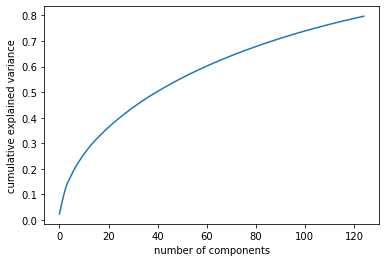

In [495]:
import matplotlib.pyplot as plt
plt.plot(np.cumsum(tsvd.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [452]:
df7.head()

,0,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,124
0,1.079488,0.166756,-0.664177,0.435997,-0.666657,-1.077805,0.834631,-0.382261,-1.179065,0.095714,...,0.385104,0.402839,0.257540,0.098062,0.021444,0.118731,0.110133,-0.109568,-0.105931,0.151978
1,1.843619,-0.852818,-0.414215,-0.034749,-0.127197,-0.682777,0.165807,0.186618,-0.032139,-0.188757,...,0.017583,-0.001201,-0.108024,0.006224,-0.046372,-0.039557,-0.049626,0.002531,-0.115787,0.014859
2,1.536162,0.045772,-0.837378,0.312137,0.141460,-0.153411,0.310379,-0.455851,-0.456844,-0.207281,...,-0.070388,-0.127883,0.061339,0.051660,0.015898,0.018430,0.045841,-0.009908,-0.032223,0.005806
3,1.756331,-0.617205,-0.139568,0.170658,0.078240,0.218845,-0.084785,0.263455,-0.160521,-0.386417,...,-0.038662,0.050597,0.097747,-0.005082,-0.104133,-0.016692,-0.010874,0.088196,-0.151884,0.011179
4,1.310773,-0.597265,0.141789,-0.623326,0.255439,-0.126778,0.205320,0.121826,0.034829,0.174755,...,0.023380,-0.071698,0.002032,0.027034,0.005684,0.039237,0.032055,-0.028730,-0.079167,0.065853


In [497]:
# Add product info back in
df7['product']=df6['product']

In [498]:
# Export data for analysis
df7.to_csv(f"{path}/data/data_clean.csv",index=True)
df7.shape

(359, 101)